In [1]:
# Imports
from compressors import lz77, huffman, lzw, arithmetic_code, utils
import pandas as p
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os, email, re

## 1. Pre processing email dataset

**Loading dataset**

In [2]:
# Loading emails csv
file_path = os.path.join(os.getcwd(), "dataset/emails.csv")
df = p.read_csv(file_path, nrows=300)
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


Transform emails raw message in a dataframe, by extract all the meta informations from the `message` field. This extra information will be usefull for clustering and partitition, and **discarted** at the compression time (we will compress the raw `message`)

In [3]:
# Adapt raw emails to objects
emails = list(map(email.parser.Parser().parsestr, df['message']))

#Extract field names from email objects
columns = emails[0].keys()

# Exploding emails metadata columns
for c in columns:
    df[c] = [info[c] for info in emails]

# Extracting emails raw texts
df['body'] = list(map(lambda e : e.get_payload(), emails))

#rename column message, to indicate that this column has the unprocessed raw data
df = df.rename(columns={"message" : "Raw-Message"})

# Parsing dates
df['Date'] = p.to_datetime(df['Date'],infer_datetime_format=True)

display(df.head(5))

,file,Raw-Message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.


**Cleaning subject and body field** : These columns are key informations on the clusterization process. So it's important normalize the data by removing abreviations, terms included by the HTML compilation (and other indformation different then pure text, that could interfer on the data meaning).

In [4]:
# Sanitizing columns
def sanitize_column(data):
    '''
        Function to cleaning text for a better analysis
    '''
    #words to be excluded from s
    exclusions = ["re", "Re", "RE", "-", "_", "\n", r'[0-9]+', r'\[[^]]*\]', r'[^\w\s]', "forwarded by phillip k allenhouect on    pm"]
    # words to be replaced
    replaces = [(r"\'ve", " have "), (r"can\`t", "cannot"), (r"n't", " not "), (r"I'm", "I am"), (r"\'re", " are "), (r"\'d", " would "), (r"\'ll", " will ")]

    if data:
        for ex in exclusions:
            data = re.sub(ex, '', data)
        
        # strip html
        p = re.compile(r'<.*?>')

        for rep in replaces:
            data = re.sub(rep[0], rep[1], data)
        
        if 'forwarded by:' in data:
            data = data.split('subject')[1]

        data = p.sub('', data)

        #strip data
        data = data.strip()
        return data
    return "Empty"

df['Subject_sanitized'] = df['Subject'].apply(sanitize_column)
df['body_sanitized'] = df['body'].apply(sanitize_column)          


**Show clusters for subject and body**

In [5]:
stop_words = set(STOPWORDS)
extra_stop_words = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa','hou', 'cc', 'etc', 'subject', 'pm', 'ect', 'com', 'recipient', "Empty"]

for word in extra_stop_words:
    stop_words.add(word)

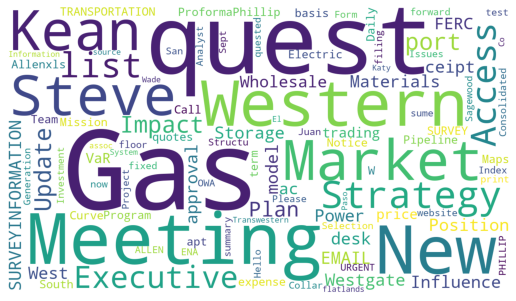

In [6]:
w_cloud = WordCloud(
    collocations=False,
    width=1400, height=800,
    background_color='white',
    stopwords=stop_words,
    max_words=100,
    random_state=42).generate(' '.join(df['Subject_sanitized']))

plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(w_cloud)
plt.axis('off')
plt.show()


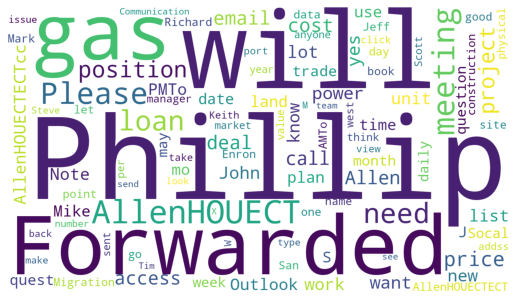

In [7]:
w_cloud = WordCloud(
    collocations=False,
    width=1400, height=800,
    background_color='white',
    stopwords=stop_words,
    max_words=100,
    random_state=42).generate(' '.join(df['body_sanitized']))

plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(w_cloud)
plt.axis('off')
plt.show()

## 2. Compressing data without clusterization partition

In [29]:
# Data to compress: Compress the original data raw
raw_text = df['Raw-Message']
text_to_encode = raw_text.sum()

In [30]:
#Initializing encoders
huffman_encoder = huffman.HuffmanCompressor(text_to_encode)
# ar_encoder = arithmetic_code.ArithmeticCompressor("Lá em casa tinha um piano, com um copo de veneno, quem bebeu morreu o culpado nao fui eu, foi o filho do abreu")
# lzw_encoder = lzw.LzwCompressor("Lá em casa tinha um piano, com um copo de veneno, quem bebeu morreu o culpado nao fui eu, foi o filho do abreu")
# lz77_encoder = lz77.Lz77Compressor("Lá em casa tinha um piano, com um copo de veneno, quem bebeu morreu o culpado nao fui eu, foi o filho do abreu")


In [31]:
huffman_encoder.encode()

#Asserting that the text is being corrected decoded
assert text_to_encode == huffman_encoder.decode()

Average code size: 5.306101708976273
Orignal size (bytes): 385728
New size (bytes): 255839
Compression rate (%): 33.673728637796586
